In [140]:
from scipy.integrate import odeint, ode
import numpy as np
import matplotlib.pyplot as plt


T, L = 5, 1  # problem [0, T] x [0, L]
t_list = np.linspace(0, T, 200)
h_list = np.linspace(0, L, 100)
dt, dh = t_list[1]-t_list[0], h_list[1]-h_list[0]


A11 = -1
alpha_1 = 0.9

A22 = -1
A21 = -0.9
n = 1

def dxi_dt(t, xi, S):
    return A11 * (xi - alpha_1 * (1 - S))


def dxith_dt(t, xi_th, S, xi, theta):  # xi_theta
    return A22 * (xi_th - theta) + A21 * ((xi_th - theta)**n) * (xi - alpha_1 * (1 - S))

In [141]:
def solve_dxi_dt_ode(S, ksi0):
    '''Solve ksi ode via Adams solver.

    :param S: Collable of 1 argument: t
    '''
    
    def wrapper(t, xi):  # remove extra arguments
        return dxi_dt(t, xi, S(t))
    
    ODE=ode(wrapper)
    ODE.set_integrator('vode') 
    ODE.set_initial_value(ksi0, 0)
    
    ksi_list = [ksi0]
    while ODE.successful() and ODE.t < T:
        ksi_list.append(ODE.integrate(ODE.t+dt)[0])
        
    if len(ksi_list) - len(t_list) == 1:
        ksi_list.pop()
        
    assert len(ksi_list) == len(t_list), 'Ksi was not resolved correctly via ODE with len ksi_list={}, t_list={}'.format(len(ksi_list), len(t_list))
    return ksi_list


def solve_dxi_th_dt_ode(S, theta, xi, xi_th0, _t):  # todo: too tricky and not time profitably
    '''Solve ksi ode via Adams solver.

    :param S: Collable of 1 argument: t
    :param Theta: Collable of 1 argument: t
    '''
    
    def wrapper(t, xi_th):  # remove extra arguments
        return dxith_dt(t, xi_th, S(t), xi, theta(t))
    
    ODE=ode(wrapper)
    ODE.set_integrator('vode') 
    ODE.set_initial_value(xi_th0, 0)
    
    xi_th_list = [xi_th0]
    while ODE.successful() and ODE.t < _t:
        xi_th_list.append(ODE.integrate(ODE.t+dt)[0])
        
    if len(xi_th_list) - len(t_list) == 1:
        xi_th_list.pop()
        
    # assert len(xi_th_list) == len(t_list), 'Xi_th was not resolved correctly via ODE with len ksi_list={}, t_list={}'.format(len(xi_th_list), len(t_list))
    return xi_th_list[-1]

Text(0.5, 1.0, 'xi (t)')

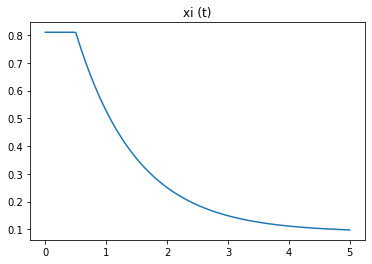

In [142]:
def S_trial(t):
    tau_k = 0.1
    Sigma = 2/3 * tau_k
    # return 0.9 - 0.8*np.exp(-t/Sigma)
    if t < 0.5:
        return 0.1
    return 0.9

def theta_trial(t):
    return 0.2# * t


xi0 = alpha_1 * (1 - S_trial(0))
xi_list = solve_dxi_dt_ode(S_trial, xi0)  # via Adams solver
plt.plot(t_list, xi_list, label='xi(t)')
# plt.plot(t_list, [S_trial(t) for t in t_list])
plt.title("xi (t)")


# xi_th0 = 0.88
# xi_th_list = [solve_dxi_th_dt_ode(S_trial, theta_trial, xi, xi_th0) for xi in xi_list]

No handles with labels found to put in legend.


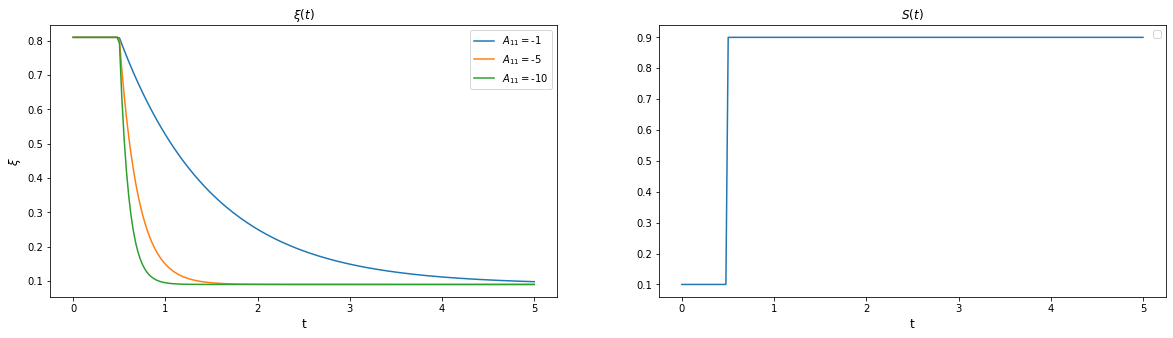

In [143]:
# different A11

remember_A11 = A11
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

for A11 in [-1, -5, -10]:
    xi0 = alpha_1 * (1 - S_trial(0))
    xi_list = solve_dxi_dt_ode(S_trial, xi0)  # via Adams solver
    
    ax1.plot(t_list, xi_list, label='$A_{11} = $' + f'{A11}')
    
ax1.set_ylabel('$\\xi$', size="large")
ax1.set_xlabel('t', size="large")
ax1.title.set_text('$\\xi (t)$')
ax1.legend()

ax2.plot(t_list, [S_trial(_t) for _t in t_list])
ax2.set_xlabel('t', size="large")
ax2.title.set_text('$S (t)$')
ax2.legend()

fig.savefig('graph_A11.png', dpi=500)

A11 = remember_A11

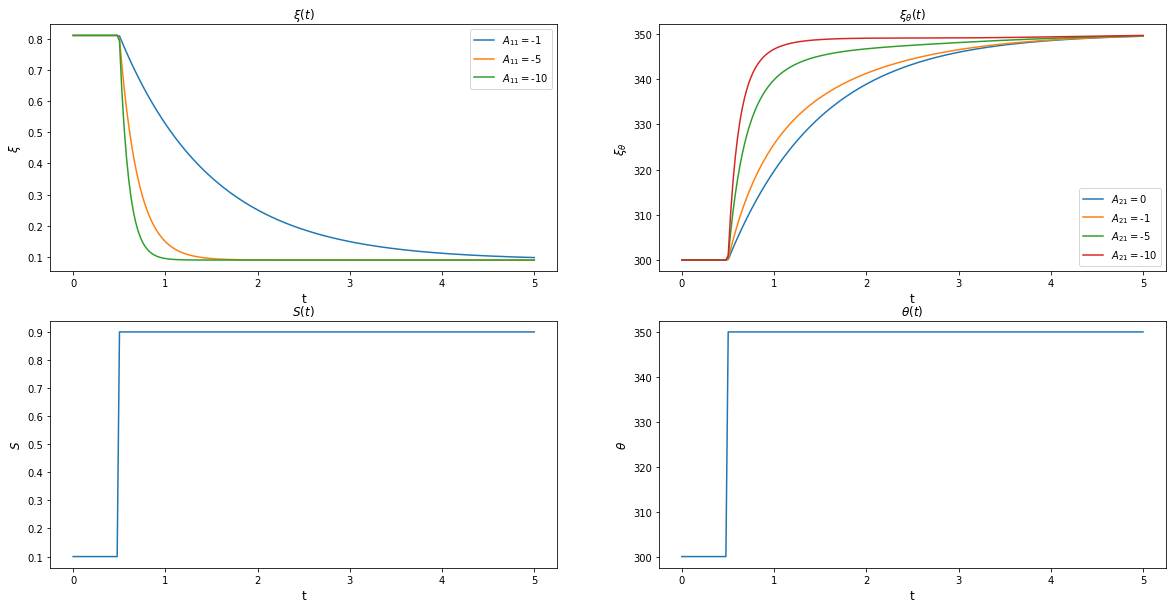

In [151]:
import functools


def S_step(t):
    if t < 0.5:
        return 0.1
    return 0.9

def theta_step(t):
    if t < 0.5:
        return 300
    else:
        return 350


xi0 = alpha_1 * (1 - S_step(0))
xi_list = solve_dxi_dt_ode(S_step, xi0)

fig, (axes) = plt.subplots(2, 2, figsize=(20,10))


_A11 = A11
for A11 in [-1, -5, -10]:
    xi0 = alpha_1 * (1 - S_step(0))
    xi_list = solve_dxi_dt_ode(S_trial, xi0)  # via Adams solver
    
    axes[0][0].plot(t_list, xi_list, label='$A_{11} = $' + f"{A11}")
    
A11 = _A11

axes[0][0].title.set_text('$\\xi(t)$')
axes[0][0].set_xlabel('t', size="large")
axes[0][0].set_ylabel('$\\xi$', size="large")
axes[0][0].legend()

_A21 = A21
for A21 in [0, -1, -5, -10]:
    xi0 = alpha_1 * (1 - S_step(0))
    xi_list = solve_dxi_dt_ode(S_trial, xi0)  # via Adams solver
    
    xi_th0 = theta_step(0)
    axes[0][1].plot(
        t_list, 
        [solve_dxi_th_dt_ode(S_trial, theta_step, xi, xi_th0, _t) for xi, _t in zip(xi_list, t_list)],
        label='$A_{21} = $' + f'{A21}'
    )
    
A21 = _A21

axes[0][1].title.set_text('$\\xi_{\\theta}(t)$')
axes[0][1].set_xlabel('t', size="large")
axes[0][1].set_ylabel('$\\xi_{\\theta}$', size="large")
axes[0][1].legend()
    
axes[1][1].plot(t_list, [theta_step(_t) for _t in t_list])
axes[1][1].title.set_text('$\\theta(t)$')
axes[1][1].set_xlabel('t', size="large")
axes[1][1].set_ylabel('$\\theta$', size="large")

axes[1][0].plot(t_list, [S_step(_t) for _t in t_list])
axes[1][0].title.set_text('$S(t)$')
axes[1][0].set_xlabel('t', size="large")
axes[1][0].set_ylabel('$S$', size="large")

fig.savefig('graph_xis.png', dpi=500)

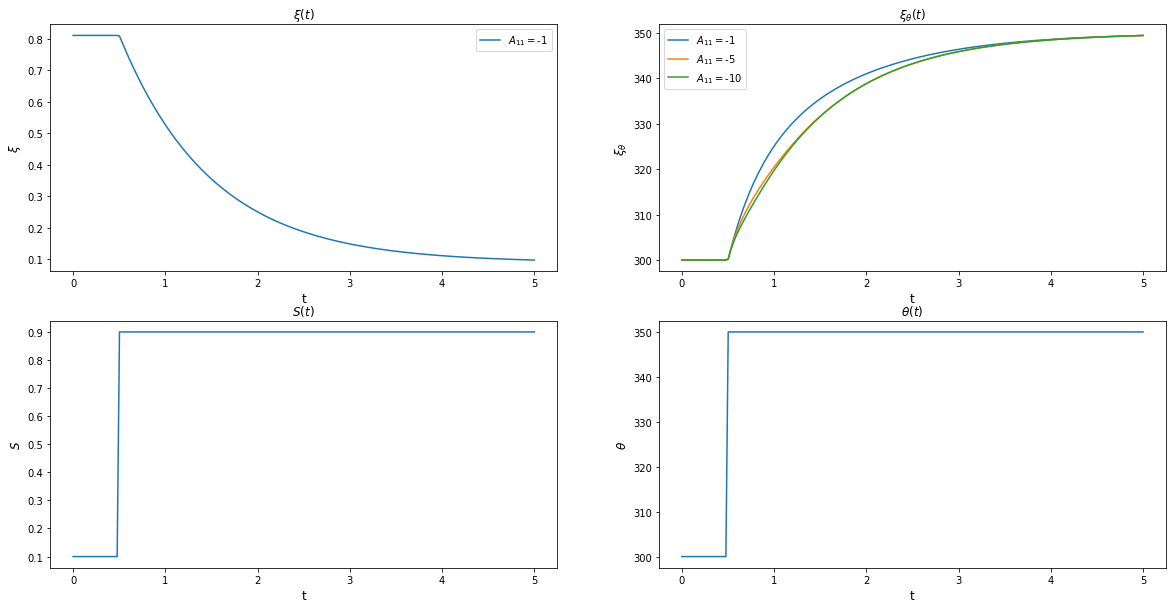

In [147]:
def S_step(t):
    if t < 0.5:
        return 0.1
    return 0.9

def theta_step(t):
    if t < 0.5:
        return 300
    else:
        return 350


xi0 = alpha_1 * (1 - S_step(0))
xi_list = solve_dxi_dt_ode(S_step, xi0)

fig, (axes) = plt.subplots(2, 2, figsize=(20,10))
axes[0][0].plot(t_list, xi_list, label='$A_{11} = $' + f"{A11}")
axes[0][0].title.set_text('$\\xi(t)$')
axes[0][0].set_xlabel('t', size="large")
axes[0][0].set_ylabel('$\\xi$', size="large")
axes[0][0].legend()

_A11 = A11
for A11 in [-1, -5, -10]:
    xi0 = alpha_1 * (1 - S_step(0))
    xi_list = solve_dxi_dt_ode(S_trial, xi0)  # via Adams solver
    
    xi_th0 = theta_step(0)
    axes[0][1].plot(
        t_list, 
        [solve_dxi_th_dt_ode(S_trial, theta_step, xi, xi_th0, _t) for xi, _t in zip(xi_list, t_list)],
        label='$A_{11} = $' + f'{A11}'
    )
    
A11 = _A11

axes[0][1].title.set_text('$\\xi_{\\theta}(t)$')
axes[0][1].set_xlabel('t', size="large")
axes[0][1].set_ylabel('$\\xi_{\\theta}$', size="large")
axes[0][1].legend()
    
axes[1][1].plot(t_list, [theta_step(_t) for _t in t_list])
axes[1][1].title.set_text('$\\theta(t)$')
axes[1][1].set_xlabel('t', size="large")
axes[1][1].set_ylabel('$\\theta$', size="large")

axes[1][0].plot(t_list, [S_step(_t) for _t in t_list])
axes[1][0].title.set_text('$S(t)$')
axes[1][0].set_xlabel('t', size="large")
axes[1][0].set_ylabel('$S$', size="large")

# fig.savefig('graph_xis_a11.png', dpi=500)

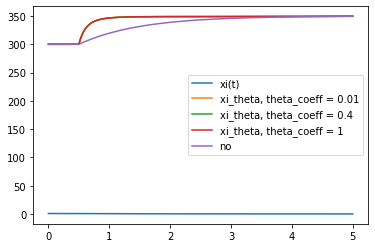

In [67]:
import functools 
A21 = -10 # TODO


def S_trial(t):
    # tau_k = 0.1
    # Sigma = 2/3 * tau_k
    # return 0.9 - 0.8*np.exp(-t/Sigma)
    if t < 0.5:
        return 0.1
    return 0.9


xi0 = alpha_1 * (1 - S_trial(0))
xi_list = solve_dxi_dt_ode(S_trial, xi0)  # via Adams solver
plt.plot(t_list, xi_list, label='xi(t)')


def liniar_theta(k, t):
    return k * t


def step_theta(t):
    if t < 0.5:
        return 300
    else:
        return 350


for theta_k in [0.01, 0.4, 1]:
    # _theta_f = functools.partial(liniar_theta, theta_k)
    _theta_f = step_theta
    
    xi_th0 = _theta_f(0)
    xi_th_list = [solve_dxi_th_dt_ode(S_trial, _theta_f, xi, xi_th0, _t) for xi, _t in zip(xi_list, t_list)]
    plt.plot(t_list, xi_th_list, label=f'xi_theta, theta_coeff = {theta_k}')
    
plt.plot(t_list, xi_th_list_no, label='no')
plt.legend()

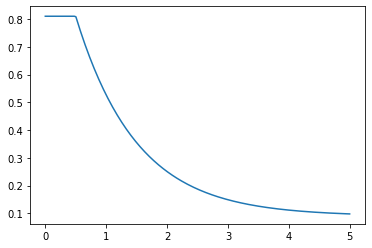

In [64]:
plt.plot(t_list, xi_list, label='xi(t)')

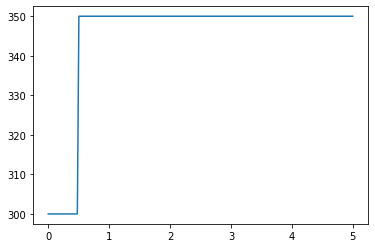

In [65]:
plt.plot(t_list, [step_theta(t) for t in t_list])
# plt.plot(t_list, xi_th_list)

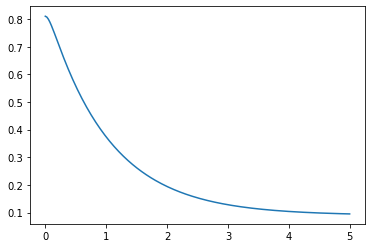

In [66]:
import functools 
A21 = 0
def S_trial(t):
    tau_k = 0.1
    Sigma = 2/3 * tau_k
    return 0.9 - 0.8*np.exp(-t/Sigma)
    # if t < 0.5:
    #     return 0.1
    # return 0.9


xi0 = alpha_1 * (1 - S_trial(0))
xi_list = solve_dxi_dt_ode(S_trial, xi0)  # via Adams solver
plt.plot(t_list, xi_list, label='xi(t)')


def liniar_theta(k, t):
    return k * t


def step_theta(t):
    if t < 0.5:
        return 300
    else:
        return 350


for theta_k in [0.01, 0.4, 1]:
    # _theta_f = functools.partial(liniar_theta, theta_k)
    _theta_f = step_theta
    
    xi_th0 = _theta_f(0)
    xi_th_list_no = [solve_dxi_th_dt_ode(S_trial, _theta_f, xi, xi_th0, _t) for xi, _t in zip(xi_list, t_list)]
    # plt.plot(t_list, xi_th_list, label=f'xi_theta, theta_coeff = {theta_k}')

# plt.legend()